# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [149]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

My final project partner: 
- Name: Yiqing Zhu
- CNet: yiqingz
- Github: yiqingzhu007
- #SID: 12144973

## ***What?*** 
We plan to analyze all film plot summaries that are available in the IMDb film archives before, during, and after major U.S. economic downturns - those time periods such as the Great Depression during the 1930s and the Great Recession in 2008. We are interested in the plot summaries of films with top box office within and across genres during these three different periods of times, so as to model and detect how do movie goers change their tastes of films before, during, and after the crisis. 

## ***Why?***
Fundamentally, U.S. has one of the largest film industry in the world, so the size of the industry ensures the number and the diversity of films in our corpora. Culturally, Hollywood has significant socioeconomic and cultural influences to the U.S. society and movie-going is recognized to be one of the popular leisure activities, so films could potentially capture changes in tastes of the U.S. society with accuracy. Academically, the modeling and detection of changes in consumer preferences have been a long-lasting topic in economics. By borrowing some concepts from economics, this project could provide some insights into both economics and film study. Practically, our model and study on the film industry during the economic downturn could also be applied to other entertainment industries or mass media, so these businesses would be able to acquire a better marketing sense of what product or service to offer during varying economic conditions. Lastly, this study could potentially generate policy implications so as to assist the government to better subsidize certain industries and to adjust and remedy market expectations during economic downturns.

## ***How?***
We have acquired text data of plot summaries from IMDb film archives and have built a database of films in order to assist identifications of popular tastes before, during, and after economic downturns within and between genres. 

We would first identify relatively popular and unpopular films during each period according to box office record. After the identification, we intend to compute distributional distances and to construct Doc2Vec models to compare the overall differences of films within and between genres before, during, and after the crisis.

Clustering techniques, such as K-means flat clustering or hierarchical clustering, and topic modeling together with machine classification would be applied to categorize films into different categories and to interpret the differences of categories before, during, and after the crisis. Such operations would be implemented to films both within genres as well as between genres. Within each category or genre, we will compute word frequency distributions and conditional word frequency distributions and identify significant collocations, to infer the semantics of each category within and between genres.

We would also train Word2Vec and Doc2Vec models within and between categories and/or genres and study projections in certain semantic dimensions. We are interested to explore the difference of depictions of certain dimensions in different categories or genres before, during, and after the crisis.


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## ***Which (words)?***
In our project, we intend to study all film plot summaries that are available in the IMDb film archives before, during, and after major U.S. economic downturns. Because IMDb archive contains all film data since 1894, our body of text is a set of comprehensive film plot summaries, thus a census.  Because our data is complete, we have no need to expand the amount of text by snowballing, neither do we need to reduce data size by random sampling since DBMS make our access to data very manageable. 

In our study, we seek to make inferences on movie-goers because U.S. has one of the largest film industry in the world having significant socioeconomic and cultural influences to the U.S. society and, at the same time, movie-going is recognized to be one of major popular leisure activities. Thus, we believe we are able to detect, model, and identify preferences of the society at different times by studying most popular or least popular films with great accuracy. 

Our research design does have potential flaws and bias. Our choice of text is movie plot summary instead of actual movie script. Plot summary has far less details and information than those carried by actual movie scripts, so our result could potentially be biased. However, consider the number of films we have in our database, quantity could potentially compensate quality. Regardless, we do think it would be wonderful if the same study could be conducted on actual movie scripts, generating better and more insightful results. However, the unsurmountable task of acquiring complete and accurate movie scripts is too good to be true. Nevertheless, if the corpus of comprehensive U.S. movie scripts that is similar to our plot summary corpus is available, we strongly believe it could be scaled up and prepare for high-profile publication.



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

My corpus contains 54 translated English novels from China, Korea, and the U.S, among which 40 are Chinese, 11 are Korean, and 3 are the U.S. 

The first approach to create a subsample of my corpus is through K-means flat clustering to see if it is possible to cluster chapters of each book after removing all identifying words such as character name and place names etc. I would like to use MTruks to let workers read several processed chapters so as to see if they are able to successfully identify whether or not they belong to the same novel. This design could help me to assess the quality of chapter clusterings.

The second approach to create a subsample of my corpus is through topic modeling so as to see if it is possible to model chapter/paragraph/sentence topics by using top words from the subset text. In this case, I would first narrow down potential topics and let workers make assessments on the same corpus and finally compare results. For example, according to my week 3's code, if I have identified top words to be "sword", "kill", "warrior", and "dagger", I would expect worker responses to be fighting scenes consistently. 

The third approach to create a subsample of my corpus is through word-embedding. I would first come up with some keywords, such as "training", "master", and "techniques", and I will use word-embedding to assess the distances between each novel/chapter/paragraphs against informative words. Once some similar novel/chapter/paragraphs are identified, I could further compare the cosine similarity scores among those larger units of text. I would need MTurk workers to read through those larger units of text such as chapters or paragraphs (not possible to be the whole book) to validate my computational results.

In general, I do not think my research question would benefit a lot from the use of MTurk without sufficient research funding since I will ask workers to perform some long and laborious reading tasks and would need them to read carefully so as to make accurate judgments. 

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [150]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [151]:
anno

Interrogate the AnnotationsContainer object.

In [152]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [153]:
anno.annotations.shape

(800, 8)

In [154]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [155]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [156]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


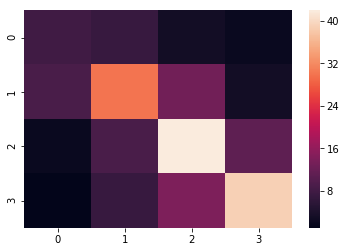

In [157]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [158]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [159]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [160]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [161]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [162]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


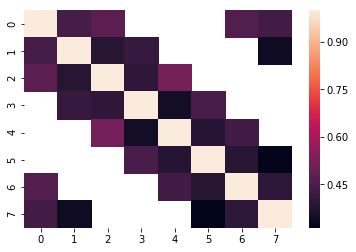

In [163]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [164]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [165]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [166]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

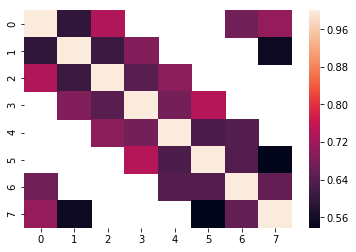

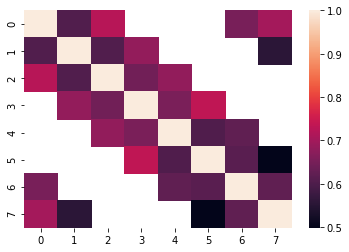

In [167]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [18]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Excercise 2*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

# Description of Data

My corpus contains 54 translated English novels from China, Korea, and U.S, among which 40 are Chinese, 11 are Korean, and 3 are U.S. The majority of the translated Chinese novels could be categorized to a genre called Eastern Fantasy as it involve topics such as Kung Fu, Sage, Chinese gods, etc.

The majority of the translated Korean novels could be categorized as fantasy. Korean novels is heavily influenced by its western counterparts. They first mimic the western novels, and gradually develope its own characteristics and style.

The U.S. novels are composed by western online readers, who are inspired by these Chinese and Korean novels and started their own literary attempt.

# Possible Hypothesis

Continuing the enlightenment from last week's assignment on word-embedding, I came up with one potential interesting research question that could be studied through MTurk, and it is to study how does the literary composition differ within and across novels at a country level?

By literary composition, I mean the porportion of different literary descriptions or characterizations that the book writer adapted when composing. According to my research, literary techniques of novels could be summarized by two broad descriptions: character and scenery, and several detailed categorizations lay within in each broad spectrum.

Character description:
- Summary depection
- Portrait depection
- Language depection
- Motion depection
- Psychological depiction 
- Detail depection


Scenery description:
- Static vs. Motion
- Objective vs. Subjective
- Comparison vs. Contrast

With all terms being defined, my potential research question of interest could be studied similiar to a two-way ANOVA model: 
- "Within" country: how does each book differ in terms of literary composition?
- "Between" country: how does novels from each country differ in terms of literary composition?

In order to ensure the quality of data and annotation obtained from MTurk, I decided to truncate the number of descriptions from 9 to 6, and they are:

{1: Portrait description, 2: Language description, 3: Motion description, 4: Scenery description, 5 Other}

# Content Annotation Survey Design

For the purpose of this assignment, I decided to try "within" country effect on one Chinese novel called "Perfect World". I want to see how would 6 different human assessments categorize 2 consecutive sentences randomly sampled from the novel. Each of 8 MTurk respondents are required to perform 100 of such tasks.

Below is a sample questions, after reading 2 sentences, the MTurk worker would be required to respond by 1-6 follwoing the categorization described above. (Possible answers could be: 1. Portrait description or 4. Motion description, etc.)

### Sample Questions:

"The little guy’s expression remained undisturbed, and he quickly took action. His palms became transparent, forming a golden color. A vigorous lightning crackled and rattled, enveloping everything instantly."  -- Perfect World Chapter 119

# Load Annotation survey data

In [168]:
pw = np.loadtxt("../data/pwTurk.txt")
pw_anno = AnnotationsContainer.from_array(pw)

Interrogate the AnnotationsContainer object.

In [169]:
pw_anno.labels

[1.0, 2.0, 3.0, 4.0, 5.0]

In [170]:
pyanno.measures.agreement.labels_frequency(pw_anno.annotations,4)

array([0.23333333, 0.24      , 0.25666667, 0.22      , 0.05      ])

Plot the confusion matrix of answers provided by 2 respondents

It shows that overall the two coders were responding relatively stably and doing great work! Motion description is identified to be the highly similiar. Scenery descriptions are also fairly identified relatively consistently, followed by protrait and language identification. 

[[18.  0.  4.  2.  1.]
 [ 1. 18.  2.  1.  2.]
 [ 1.  0. 21.  0.  0.]
 [ 2.  1.  2. 15.  4.]
 [ 0.  2.  3.  0.  0.]]


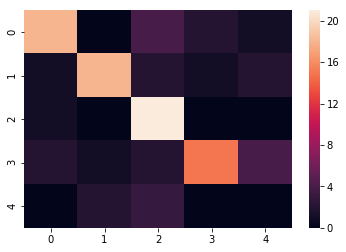

In [171]:
pw_c = pyanno.measures.agreement.confusion_matrix(pw_anno.annotations[:,0], pw_anno.annotations[:,1], nclasses = 5)
print(pw_c)
ac = seaborn.heatmap(pw_c)
plt.show()

### Because the 5 of my codes are categorical and qualitatively distinct from each other, I intend     to use Scott's $\pi$ and Cohen's $\kappa$ to assess inter-coder agreement.

Assess agreement by Scott's $\pi$               

[[1.         0.63803245 0.68897816 0.6994839  0.66231573 0.6000774 ]
 [0.63803245 1.         0.66266623 0.68772364 0.62318087 0.67683557]
 [0.68897816 0.66266623 1.         0.73885226 0.66196451 0.63817277]
 [0.6994839  0.68772364 0.73885226 1.         0.67266776 0.66214021]
 [0.66231573 0.62318087 0.66196451 0.67266776 1.         0.65048544]
 [0.6000774  0.67683557 0.63817277 0.66214021 0.65048544 1.        ]]


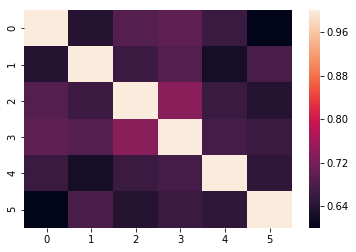

In [173]:
pw_m = pairwise_matrix(scotts_pi, pw_anno.annotations) 
print(pw_m)  
ax = seaborn.heatmap(pw_m)
plt.show()    

Assess agreement by Cohen's $\kappa$                  

[[1.         0.63987138 0.68923993 0.69966049 0.66255678 0.60066984]
 [0.63987138 1.         0.66334326 0.68992248 0.62415759 0.67741935]
 [0.68923993 0.66334326 1.         0.73931178 0.66203042 0.63828963]
 [0.69966049 0.68992248 0.73931178 1.         0.67303165 0.66303784]
 [0.66255678 0.62415759 0.66203042 0.67303165 1.         0.65071151]
 [0.60066984 0.67741935 0.63828963 0.66303784 0.65071151 1.        ]]


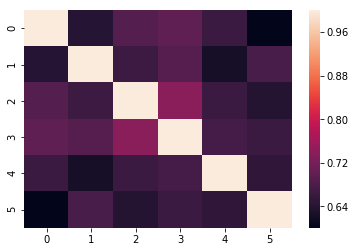

In [174]:
pw_m = pairwise_matrix(cohens_kappa, pw_anno.annotations)
print(pw_m)
ax = seaborn.heatmap(pw_m)
plt.show()

In conclusion, although the heatmap exhibits many cold spots, but looking at the scale matrix, we could see on average, the degree of similiarity is about 0.6-0.7, which is, from my perspective, relatively high. I think in general, the coders are performing relatively well. However, one flaw I have identified in my implementation after reflecting my survey design is that I let coders make their judgement based on 2 sentences when there could be situations that each sentence from the two could have different categorizations. My intention of putting two sentences is to help coders to get a better understanding of the corpus. However, I think it is not a good practice. Thus, I think the reliability of human assessments regarding my project is good and reliable, but a careful survey design is very necessary.

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading. The following image schematically describes these models. <img src="../data/pyanno/Bmodel.png">

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

In [175]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.68925656 0.2184331  0.07689508 0.01541526]
  [0.17417199 0.63564874 0.0754004  0.11477886]
  [0.02005156 0.18884058 0.76278737 0.02832049]
  [0.01316994 0.02628923 0.24639955 0.71414128]]

 [[0.55472258 0.27375374 0.03749487 0.13402881]
  [0.08725031 0.38995997 0.2957545  0.22703522]
  [0.06435162 0.00942087 0.70115034 0.22507717]
  [0.06755606 0.10381527 0.25876986 0.5698588 ]]

 [[0.68748061 0.17593086 0.08491023 0.0516783 ]
  [0.21396794 0.54820418 0.20196125 0.03586664]
  [0.12760937 0.13051195 0.62772203 0.11415664]
  [0.01746776 0.03356315 0.24238027 0.70658882]]

 [[0.79039469 0.07037114 0.10821416 0.03102002]
  [0.08368064 0.67111338 0.13919711 0.10600887]
  [0.06952807 0.23461899 0.55723698 0.13861596]
  [0.00486849 0.20164484 0.17057464 0.62291203]]

 [[0.76783154 0.10818591 0.10602743 0.01795512]
  [0.10623377 0.64820659 0.19245319 0.05310645]
  [0.10857302 0.07070329 0.7572816  0.06344209]
  [0.12260205 0.09655427 0.03290684 0.74793684]]

 [[0.7929382  0.13834583 0.039

Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [176]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [177]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Uncomment the cell below if you would rather train by MLE.

In [ ]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [178]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [179]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x11c583ef0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11ef7d550>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11f19e550>))

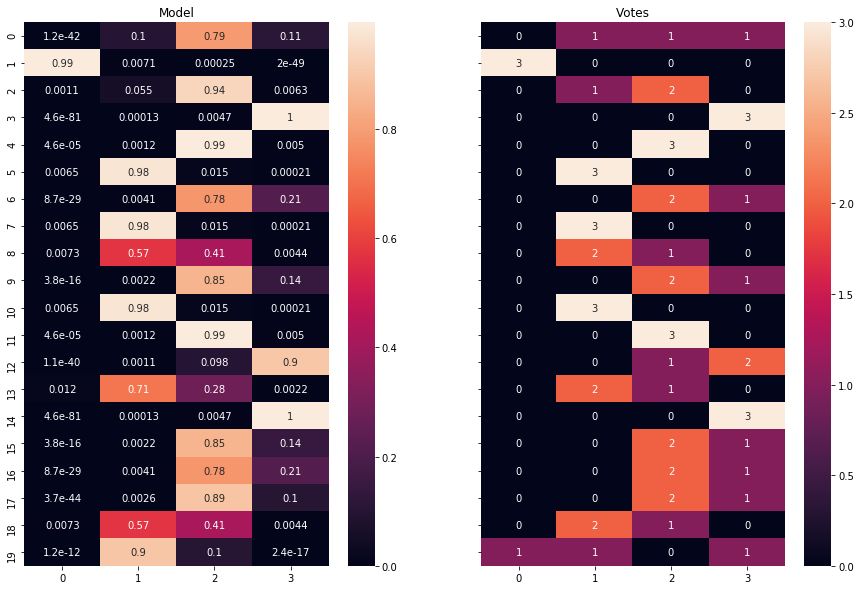

In [180]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [181]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.67278699 0.71865216 0.71962111 0.73050595 0.73777722 0.66444622
 0.63107084 0.88337264]
-3297.094259803429


In [182]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.7912744  0.74070597 0.76224809 0.7252756  0.71641594 0.71859611
 0.77321537 0.7166528 ]
-2811.9462280126772


In [183]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.76796097, 0.78180729, 0.71192687, ..., 0.77439614, 0.75985537,
        0.6901792 ],
       [0.76796097, 0.78180729, 0.71192687, ..., 0.77439614, 0.75985537,
        0.6901792 ],
       [0.76664562, 0.74671882, 0.68499645, ..., 0.72154154, 0.72774864,
        0.68598999],
       ...,
       [0.77517022, 0.72748388, 0.7941407 , ..., 0.70418537, 0.76184978,
        0.71093814],
       [0.74759419, 0.74867547, 0.75525484, ..., 0.680501  , 0.72697618,
        0.69195004],
       [0.74759419, 0.74867547, 0.75525484, ..., 0.680501  , 0.72697618,
        0.69195004]])

In [184]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.011102   0.28930798 0.3649094  0.33468062]
 [0.99021757 0.00242034 0.00405134 0.00331074]
 [0.00250008 0.05509774 0.93456628 0.00783591]
 ...
 [0.0025295  0.04397769 0.94556468 0.00792813]
 [0.00249446 0.00571562 0.93246682 0.0593231 ]
 [0.03189717 0.93880387 0.01612317 0.0131758 ]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

(<matplotlib.figure.Figure at 0x11c6d3198>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11ed15eb8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11ed70a90>))

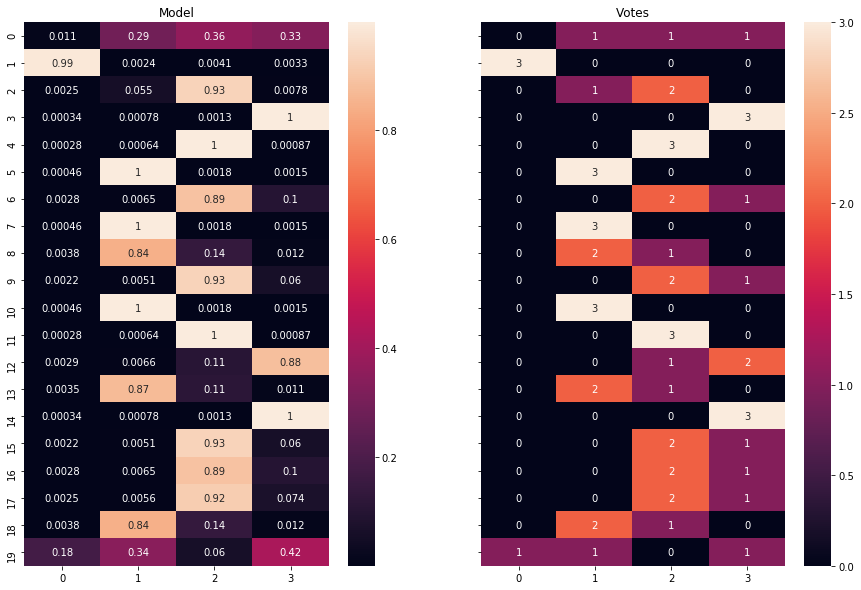

In [185]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

## Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [186]:
model = ModelBt.create_initial_state(4,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

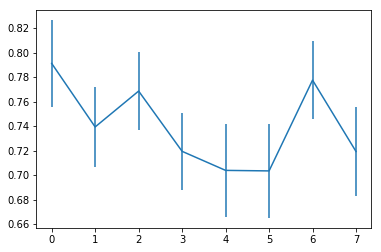

In [187]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Hotel Reviews

If we want to do a simpler analysis we can look at a different data set, here are some hotel reviews from [expedia](https://www.kaggle.com/c/expedia-hotel-recommendations)

In [188]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [189]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

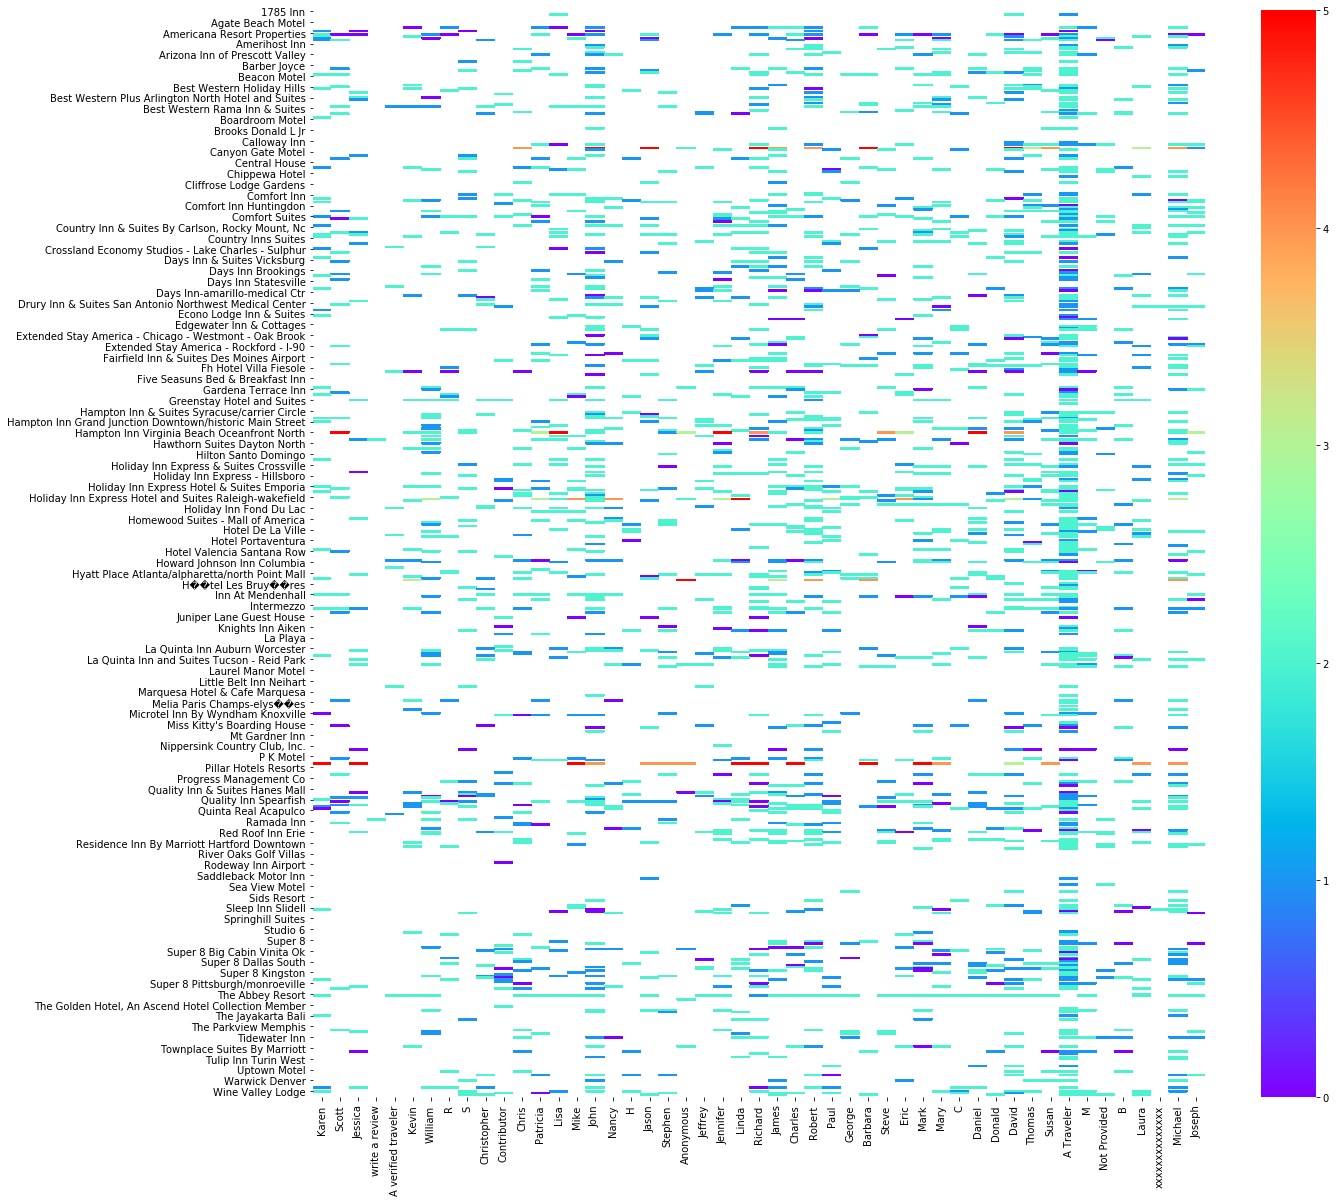

In [190]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [191]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [192]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [193]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [194]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [195]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


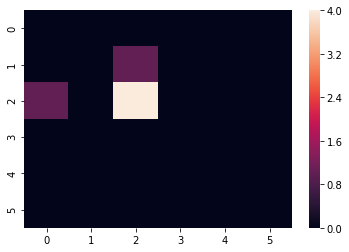

In [196]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [197]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [198]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [199]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

//anaconda/lib/python3.5/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


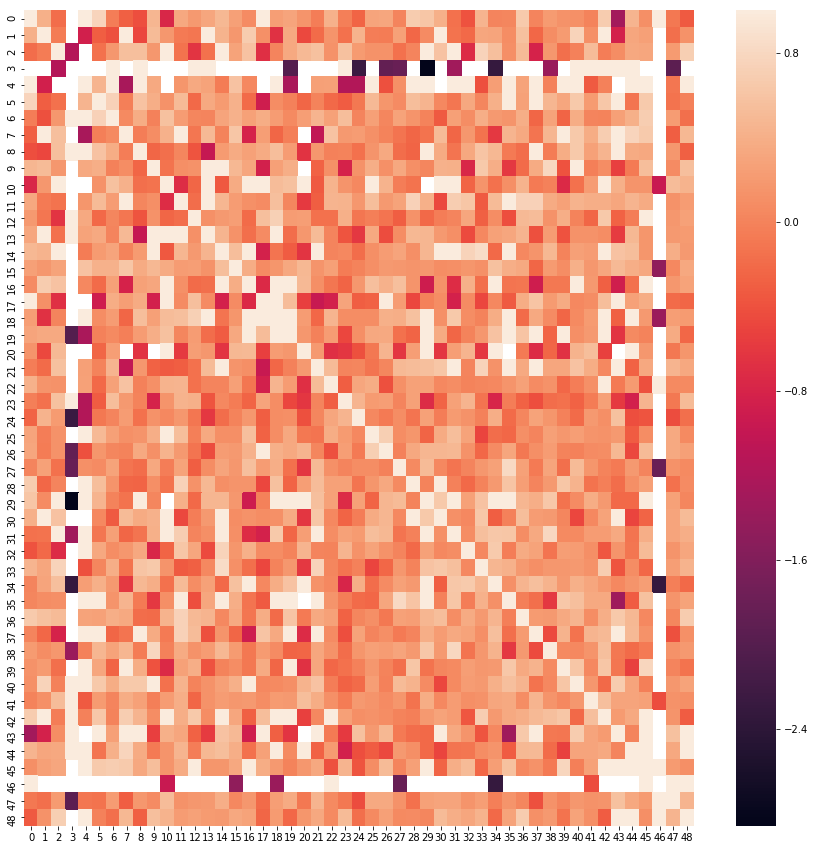

In [200]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

And to look at what model Bt thinkgs the correct reviews are:

In [201]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
#print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

-2709.872257453555


(<matplotlib.figure.Figure at 0x11f4c4be0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11ef7abe0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11f47aeb8>))

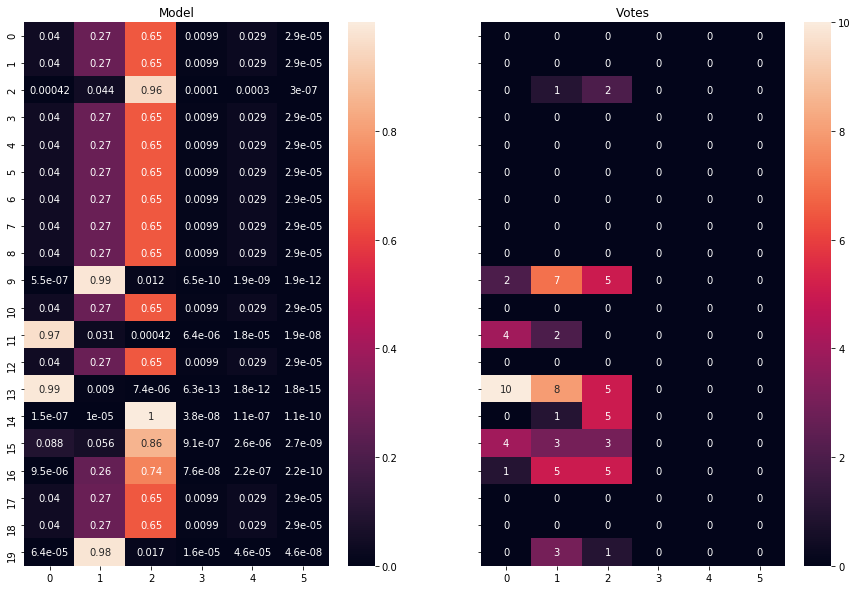

In [202]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

### In order to identify if some coders are better than others, I intend to use ModelB to assess whether there is any superiority among coders in terms of accuracy

In [203]:
# create a new instance of model B, with 5 label classes
pwModel = ModelB.create_initial_state(5,6)    

In [204]:
# other model parameters are initialized from the model prior                      
print(pwModel.theta)                                                               
print(pwModel.log_likelihood(pw_anno.annotations)) 

[[[0.67538426 0.22166993 0.05888532 0.02913151 0.01492897]
  [0.15176277 0.60712558 0.19525421 0.01881782 0.02703962]
  [0.02368257 0.21499865 0.52143939 0.15141184 0.08846755]
  [0.00099433 0.07225987 0.03322489 0.76047943 0.13304147]
  [0.01066964 0.07169655 0.011222   0.21061286 0.69579895]]

 [[0.6257543  0.28435901 0.04312114 0.00888462 0.03788092]
  [0.07819586 0.76135782 0.14316803 0.01061785 0.00666044]
  [0.02519113 0.07811274 0.76863262 0.0924394  0.03562411]
  [0.00365326 0.07471421 0.13372281 0.68829604 0.09961367]
  [0.09212525 0.01169391 0.14730537 0.09303805 0.65583742]]

 [[0.74913439 0.15795179 0.05839631 0.0237817  0.01073581]
  [0.27816439 0.53204438 0.12472938 0.04436181 0.02070004]
  [0.00805792 0.13161886 0.71602164 0.05613726 0.08816431]
  [0.02146036 0.14961088 0.22481639 0.44500432 0.15910804]
  [0.00602906 0.0969848  0.05404598 0.10787764 0.73506252]]

 [[0.63251984 0.14266849 0.09578558 0.00779935 0.12122674]
  [0.09718399 0.51459484 0.16129033 0.19701999 0.0

Train the model on data using MAP (maximum a posteriori estimation) to estimate the model parameters.

In [205]:
pwSamples = pwModel.sample_posterior_over_accuracy(pw_anno.annotations, 200, burn_in_samples=100, thin_samples=3)

After getting model parameters, make inferences about the true label classes.

In [208]:
pwPosterior = pwModel.infer_labels(pw_anno.annotations)                            

(<matplotlib.figure.Figure at 0x11c714828>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11e51e550>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10bd33978>))

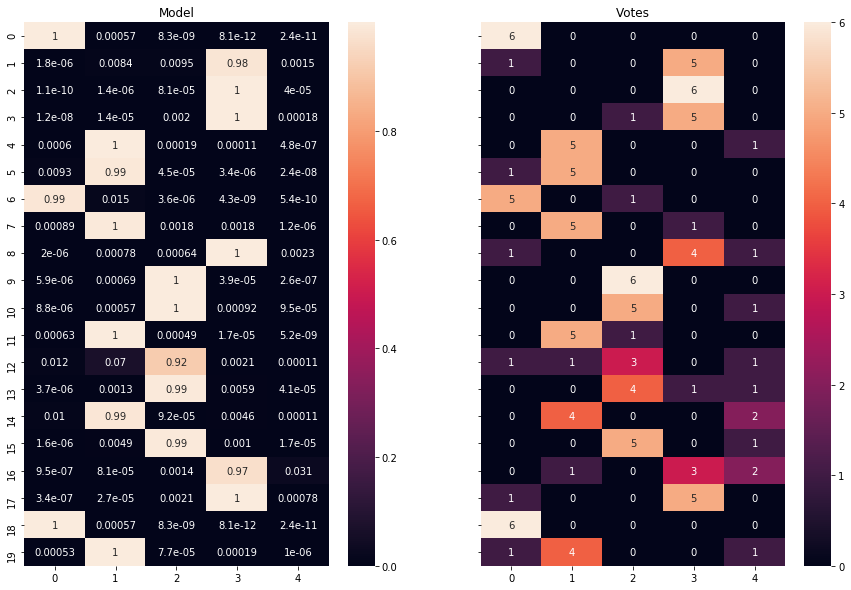

In [207]:
makeQuestionComparison(pwModel, pw_anno)

According to the comparison plot presented above, the model-based probabilities are on left; the raw votes on right. We could tell there are some questions are very straightforward that almost everyone got it right. However, at the same time, we could see that there are cases when there are (5, 1) pairs: meaning 5 people made it right but 1 person failed to identified correctly according to our model. 

Try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [209]:
pwModelBt = ModelBt.create_initial_state(5,6)                                                       
print(pwModelBt.theta)                                                                              
print(pwModelBt.log_likelihood(pw_anno.annotations)) 

[0.78630065 0.80000021 0.66560959 0.84211401 0.65125453 0.85431758]
-579.9678315798632


In [210]:
pwModelBt.map(pw_anno.annotations)                                                                  
print(pwModelBt.theta)                                                                              
print(pwModelBt.log_likelihood(pw_anno.annotations))  

[0.87085213 0.84196364 0.87158687 0.89082786 0.85068141 0.82181919]
-502.78746860408273


In [211]:
pwModelBt.sample_posterior_over_accuracy(pw_anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.90790202, 0.81298549, 0.85770151, 0.8988352 , 0.76723891,
        0.82519263],
       [0.853019  , 0.83894417, 0.87426787, 0.90384257, 0.81228155,
        0.8145447 ],
       [0.853019  , 0.83894417, 0.87426787, 0.90384257, 0.81228155,
        0.8145447 ],
       ...,
       [0.90058411, 0.82354655, 0.8737688 , 0.90936489, 0.87312873,
        0.80978514],
       [0.86122343, 0.81223251, 0.89214714, 0.88106174, 0.89773267,
        0.77397721],
       [0.86122343, 0.81223251, 0.89214714, 0.88106174, 0.89773267,
        0.77397721]])

In [217]:
pwPosterior_modelBt = pwModelBt.infer_labels(pw_anno.annotations)               

### Visualize the posterior of the first 10 samples according to ModelBt.

(<matplotlib.figure.Figure at 0x11c6eb278>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11e452048>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11eb43fd0>))

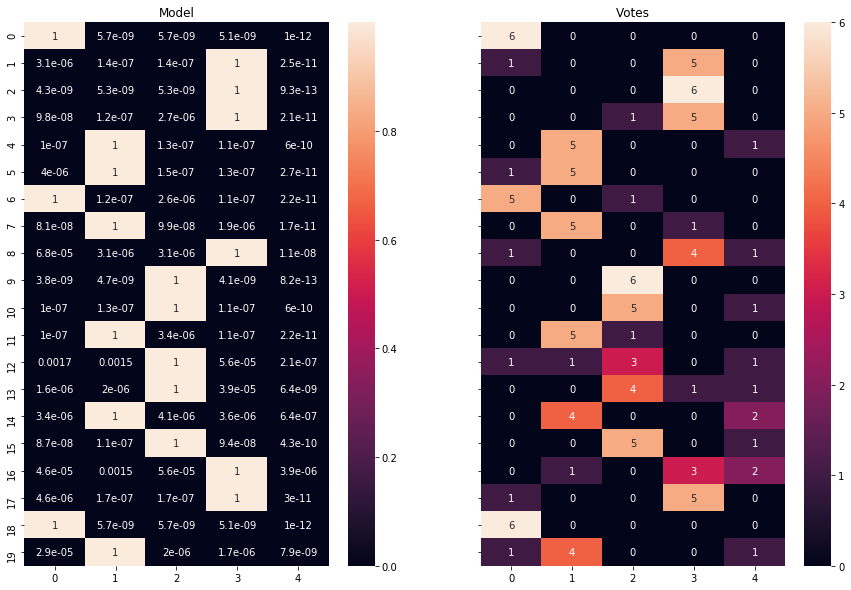

In [213]:
makeQuestionComparison(pwModelBt, pw_anno)    

It could be seen that after using ModelBt, each coder has a single estimate over the accuracy of all of their codes.

# Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt.

In [214]:
model = ModelBt.create_initial_state(5,6)
model.mle(pw_anno.annotations)
samples = model.sample_posterior_over_accuracy(pw_anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

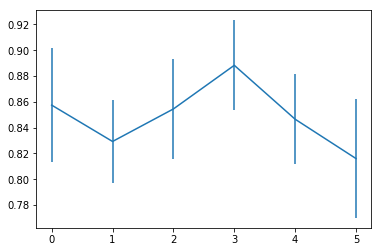

In [216]:
plt.figure()
plt.errorbar(range(6),y, yerr = y_ci)
plt.show()

In conclusion, after visualizing coder accuracy, we could see coder 3 performed the best while coder 1, coder2, and coder5 were performing relatively accurate. Coder 1 and coder 5 were relatively low-performing coders, and I will consider to drop coder 5 from my study.

Also very interestingly, if we view the plot vertically, we could tell the skill distribution of coders are fairly normal after aggregating those 5 intervals. 